<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Computing-embs" data-toc-modified-id="Computing-embs-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Computing embs</a></span></li><li><span><a href="#Thresh-grid-search" data-toc-modified-id="Thresh-grid-search-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Thresh grid search</a></span><ul class="toc-item"><li><span><a href="#grid-search" data-toc-modified-id="grid-search-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>grid search</a></span><ul class="toc-item"><li><span><a href="#Full-dataset" data-toc-modified-id="Full-dataset-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Full dataset</a></span></li><li><span><a href="#train-dataset" data-toc-modified-id="train-dataset-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>train dataset</a></span></li><li><span><a href="#val-dataset" data-toc-modified-id="val-dataset-2.1.3"><span class="toc-item-num">2.1.3&nbsp;&nbsp;</span>val dataset</a></span></li></ul></li></ul></li><li><span><a href="#Only-resnet50" data-toc-modified-id="Only-resnet50-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Only resnet50</a></span></li><li><span><a href="#Tests" data-toc-modified-id="Tests-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Tests</a></span></li></ul></div>

In [1]:
import os
import random
import functools
from functools import partial
import PIL

import numpy as np 
import pandas as pd

from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

import timm

from transformers import BertTokenizer
from transformers import BertModel

from data_process import TripletDS, text_to_device
from models import EmbedorNN
np.random.seed(1337)

ModuleNotFoundError: No module named 'timm'

## Computing embs

In [24]:
??EmbedorNN

In [2]:
# load in data
df = pd.read_csv('data/train.csv')
small_images_dir = 'data/small_train_images'

# train val split

train_perc = 0.7
n_train_examples = int(train_perc * len(df))

train_df = df.iloc[:n_train_examples]
val_df = df.iloc[n_train_examples:]

# creating dataloaders

vision_model = 'resnet50'
language_model = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(language_model)


bs = 32
tr_ds = TripletDS(train_df, tokenizer, small_images_dir)
tr_dl = DataLoader(tr_ds, batch_size = bs, shuffle = True, pin_memory = True)

val_ds = TripletDS(val_df, tokenizer, small_images_dir)
val_dl = DataLoader(val_ds, batch_size = bs, shuffle = False, pin_memory = True)

device = torch.device('cuda')

In [3]:
model = EmbedorNN(vision_model, language_model).to(device)

In [5]:
model.load_state_dict(torch.load('data/loss_9_0.005.pt'))

<All keys matched successfully>

In [7]:
testing_ds = TripletDS(df, tokenizer, small_images_dir, return_triplet = False)
testing_dl = DataLoader(testing_ds, batch_size = bs, shuffle = False, pin_memory = True)

In [10]:
normalize = transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                 std=(0.229, 0.224, 0.225))

val_transforms = transforms.Compose([transforms.Resize((224,224)),
                                     normalize
                                     ])

In [11]:
embs = []
model.eval()
with torch.no_grad():
    pbar = tqdm(testing_dl)
    for image, text in pbar:
        x = val_transforms(image.to(device)), text_to_device(text, device)
        y = model(x)
        embs.append(y.cpu())

In [12]:
embs = torch.cat(embs,0)

embs_df = pd.DataFrame(embs.numpy())
emb_cols = [f'emb_{i}' for i in embs_df.columns]
embs_df.columns = emb_cols
embs_df.to_csv('train_embs.csv')


embs_df.to_csv('train_embs.csv')

## Thresh grid search 

In [3]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [4]:
from cuml.neighbors import NearestNeighbors

In [5]:
embs, labels = pd.read_csv('train_embs.csv', index_col=0), torch.load('labels.ph')

In [6]:
np.random.seed(1337)

train_perc = 0.7
n_train_examples = int(train_perc * len(embs))

train_labels = labels.iloc[:n_train_examples]
val_labels = labels.iloc[n_train_examples:]

In [7]:
train_embs = embs[:n_train_examples]
val_embs = embs[n_train_examples:]

In [8]:
embs.head()

,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,...,emb_502,emb_503,emb_504,emb_505,emb_506,emb_507,emb_508,emb_509,emb_510,emb_511
0,0.038600,-0.044721,-0.041830,-0.083153,0.023948,-0.019448,-0.042530,-0.024029,0.037545,-0.038466,...,0.063109,-0.079494,-0.047503,0.081542,-0.026238,0.049447,-0.059719,0.002430,-0.039005,0.030931
1,0.001940,-0.016763,0.035275,-0.016450,-0.046662,0.016345,-0.009769,-0.146457,0.000695,-0.037863,...,0.064661,-0.038906,-0.011562,-0.038165,0.001208,-0.040753,0.024289,-0.001972,0.013571,-0.003906
2,0.016056,-0.014849,0.093197,-0.040614,-0.035620,0.013535,-0.019464,-0.018314,-0.036119,-0.005769,...,0.018305,-0.034129,-0.037804,-0.037323,0.087867,-0.018376,0.038292,-0.060192,0.024330,-0.073779
3,-0.054010,0.004885,0.023995,-0.018338,0.071442,0.024827,-0.059285,0.004270,-0.018626,0.048731,...,0.054015,-0.031777,-0.066990,0.034834,-0.010072,0.009164,-0.034217,0.021796,0.028507,0.039108
4,-0.032548,0.057746,0.010266,-0.040914,-0.063721,-0.035756,0.066674,0.010233,-0.123327,0.033831,...,-0.039506,0.017430,-0.028667,-0.035315,-0.020148,-0.054920,0.009865,0.088304,0.007486,-0.044139


In [9]:
embs.shape, labels.shape

((34250, 512), (34250,))

In [34]:
def compute_f1(embeddings, ls, threshold) :
    knn = NearestNeighbors(50)
    knn.fit(embeddings)
    
    print('Computing distances...')
    distances, indices = knn.kneighbors(embeddings)
    
    print('Making predictions...')
    THRESHOLD = threshold
    preds = [[] for _ in range(embeddings.shape[0])]
    for i in tqdm(range(distances.shape[0])) :
        IDX = np.where(distances[i,]<THRESHOLD)[0]
        IDS = indices[i,IDX]
        preds[i] = IDS
            
    print('Computing f1 score...')
    label_counts = ls.value_counts()
    f_score = 0 
    for i in tqdm(range(embeddings.shape[0])) :
        tp = 0
        fp = 0
        true_label = ls.iloc[i]
        for index in preds[i] :
            if ls.iloc[index] == true_label :
                tp += 1
            else :
                fp += 1
        fn = label_counts[true_label] - tp
        #print(label_counts[true_label]-1, tp)
        f_score += 2*tp / (label_counts[true_label] + len(preds[i]))
    f_score = f_score/embeddings.shape[0]
    print('f1 score : {}'.format(f_score))
    return f_score, preds, distances, indices

In [8]:
dists = pairwise_distances(embs[0:4], embs)

In [35]:
f_score, preds, dists, indx = compute_f1(embs, labels, 0.5)

Computing distances...
Making predictions...


  0%|          | 0/34250 [00:00<?, ?it/s]

Computing f1 score...


  0%|          | 0/34250 [00:00<?, ?it/s]

f1 score : 0.6494399948480348


### grid search

#### Full dataset

In [6]:
def plot_scores(sc) :
    thrs, scs = zip(*sc)
    plt.plot(thrs, scs)
    plt.show()

In [12]:
scores = [(thr, compute_f1(embs, labels, thr)[0]) for thr in np.linspace(0.001, 1, 10)]

Computing distances...
Making predictions...


  0%|          | 0/34250 [00:00<?, ?it/s]

Computing f1 score...


  0%|          | 0/34250 [00:00<?, ?it/s]

f1 score : 0.44085510399846195
Computing distances...
Making predictions...


  0%|          | 0/34250 [00:00<?, ?it/s]

Computing f1 score...


  0%|          | 0/34250 [00:00<?, ?it/s]

f1 score : 0.47707558388539634
Computing distances...
Making predictions...


  0%|          | 0/34250 [00:00<?, ?it/s]

Computing f1 score...


  0%|          | 0/34250 [00:00<?, ?it/s]

f1 score : 0.531335222232999
Computing distances...
Making predictions...


  0%|          | 0/34250 [00:00<?, ?it/s]

Computing f1 score...


  0%|          | 0/34250 [00:00<?, ?it/s]

f1 score : 0.6141174034283127
Computing distances...
Making predictions...


  0%|          | 0/34250 [00:00<?, ?it/s]

Computing f1 score...


  0%|          | 0/34250 [00:00<?, ?it/s]

f1 score : 0.6582326927090401
Computing distances...
Making predictions...


  0%|          | 0/34250 [00:00<?, ?it/s]

Computing f1 score...


  0%|          | 0/34250 [00:00<?, ?it/s]

f1 score : 0.618215672372117
Computing distances...
Making predictions...


  0%|          | 0/34250 [00:00<?, ?it/s]

Computing f1 score...


  0%|          | 0/34250 [00:00<?, ?it/s]

f1 score : 0.5048914281218272
Computing distances...
Making predictions...


  0%|          | 0/34250 [00:00<?, ?it/s]

Computing f1 score...


  0%|          | 0/34250 [00:00<?, ?it/s]

f1 score : 0.34633900550480484
Computing distances...
Making predictions...


  0%|          | 0/34250 [00:00<?, ?it/s]

Computing f1 score...


  0%|          | 0/34250 [00:00<?, ?it/s]

f1 score : 0.21426705948258165
Computing distances...
Making predictions...


  0%|          | 0/34250 [00:00<?, ?it/s]

Computing f1 score...


  0%|          | 0/34250 [00:00<?, ?it/s]

f1 score : 0.17636797150439332


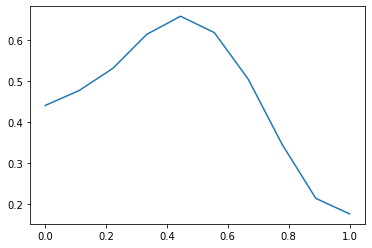

In [24]:
plot_scores(scores)

In [25]:
scores = [(thr, compute_f1(embs, labels, thr)[0]) for thr in np.linspace(0.4, 0.6, 10)]

Computing distances...
Making predictions...


  0%|          | 0/34250 [00:00<?, ?it/s]

Computing f1 score...


  0%|          | 0/34250 [00:00<?, ?it/s]

f1 score : 0.6483319127584861
Computing distances...
Making predictions...


  0%|          | 0/34250 [00:00<?, ?it/s]

Computing f1 score...


  0%|          | 0/34250 [00:00<?, ?it/s]

f1 score : 0.655645383146149
Computing distances...
Making predictions...


  0%|          | 0/34250 [00:00<?, ?it/s]

Computing f1 score...


  0%|          | 0/34250 [00:00<?, ?it/s]

f1 score : 0.6582020831707546
Computing distances...
Making predictions...


  0%|          | 0/34250 [00:00<?, ?it/s]

Computing f1 score...


  0%|          | 0/34250 [00:00<?, ?it/s]

f1 score : 0.657021008166676
Computing distances...
Making predictions...


  0%|          | 0/34250 [00:00<?, ?it/s]

Computing f1 score...


  0%|          | 0/34250 [00:00<?, ?it/s]

f1 score : 0.652769157030126
Computing distances...
Making predictions...


  0%|          | 0/34250 [00:00<?, ?it/s]

Computing f1 score...


  0%|          | 0/34250 [00:00<?, ?it/s]

f1 score : 0.6452712565844787
Computing distances...
Making predictions...


  0%|          | 0/34250 [00:00<?, ?it/s]

Computing f1 score...


  0%|          | 0/34250 [00:00<?, ?it/s]

f1 score : 0.6338581711173628
Computing distances...
Making predictions...


  0%|          | 0/34250 [00:00<?, ?it/s]

Computing f1 score...


  0%|          | 0/34250 [00:00<?, ?it/s]

f1 score : 0.6186362197134734
Computing distances...
Making predictions...


  0%|          | 0/34250 [00:00<?, ?it/s]

Computing f1 score...


  0%|          | 0/34250 [00:00<?, ?it/s]

f1 score : 0.601012062173885
Computing distances...
Making predictions...


  0%|          | 0/34250 [00:00<?, ?it/s]

Computing f1 score...


  0%|          | 0/34250 [00:00<?, ?it/s]

f1 score : 0.5802006126401967


#### train dataset

In [33]:
train_labels.shape, train_embs.shape

((23975,), (23975, 512))

In [36]:
scores = [(thr, compute_f1(train_embs, train_labels, thr)[0]) for thr in np.linspace(0.001, 1, 10)]

Computing distances...
Making predictions...


  0%|          | 0/23975 [00:00<?, ?it/s]

Computing f1 score...


  0%|          | 0/23975 [00:00<?, ?it/s]

f1 score : 0.5298056303782903
Computing distances...
Making predictions...


  0%|          | 0/23975 [00:00<?, ?it/s]

Computing f1 score...


  0%|          | 0/23975 [00:00<?, ?it/s]

f1 score : 0.5674151316140864
Computing distances...
Making predictions...


  0%|          | 0/23975 [00:00<?, ?it/s]

Computing f1 score...


  0%|          | 0/23975 [00:00<?, ?it/s]

f1 score : 0.6136102267624285
Computing distances...
Making predictions...


  0%|          | 0/23975 [00:00<?, ?it/s]

Computing f1 score...


  0%|          | 0/23975 [00:00<?, ?it/s]

f1 score : 0.6834033095473236
Computing distances...
Making predictions...


  0%|          | 0/23975 [00:00<?, ?it/s]

Computing f1 score...


  0%|          | 0/23975 [00:00<?, ?it/s]

f1 score : 0.7133076756443674
Computing distances...
Making predictions...


  0%|          | 0/23975 [00:00<?, ?it/s]

Computing f1 score...


  0%|          | 0/23975 [00:00<?, ?it/s]

f1 score : 0.6591160415748419
Computing distances...
Making predictions...


  0%|          | 0/23975 [00:00<?, ?it/s]

Computing f1 score...


  0%|          | 0/23975 [00:00<?, ?it/s]

f1 score : 0.527219676869062
Computing distances...
Making predictions...


  0%|          | 0/23975 [00:00<?, ?it/s]

Computing f1 score...


  0%|          | 0/23975 [00:00<?, ?it/s]

f1 score : 0.3503449328123086
Computing distances...
Making predictions...


  0%|          | 0/23975 [00:00<?, ?it/s]

Computing f1 score...


  0%|          | 0/23975 [00:00<?, ?it/s]

f1 score : 0.1972737872213963
Computing distances...
Making predictions...


  0%|          | 0/23975 [00:00<?, ?it/s]

Computing f1 score...


  0%|          | 0/23975 [00:00<?, ?it/s]

f1 score : 0.14764991593955018


#### val dataset 

In [37]:
scores = [(thr, compute_f1(val_embs, val_labels, thr)[0]) for thr in np.linspace(0.001, 1, 10)]

Computing distances...
Making predictions...


  0%|          | 0/10275 [00:00<?, ?it/s]

Computing f1 score...


  0%|          | 0/10275 [00:00<?, ?it/s]

f1 score : 0.6920304638392997
Computing distances...
Making predictions...


  0%|          | 0/10275 [00:00<?, ?it/s]

Computing f1 score...


  0%|          | 0/10275 [00:00<?, ?it/s]

f1 score : 0.7353983272568838
Computing distances...
Making predictions...


  0%|          | 0/10275 [00:00<?, ?it/s]

Computing f1 score...


  0%|          | 0/10275 [00:00<?, ?it/s]

f1 score : 0.763902235128316
Computing distances...
Making predictions...


  0%|          | 0/10275 [00:00<?, ?it/s]

Computing f1 score...


  0%|          | 0/10275 [00:00<?, ?it/s]

f1 score : 0.7953294579636402
Computing distances...
Making predictions...


  0%|          | 0/10275 [00:00<?, ?it/s]

Computing f1 score...


  0%|          | 0/10275 [00:00<?, ?it/s]

f1 score : 0.7894377165031298
Computing distances...
Making predictions...


  0%|          | 0/10275 [00:00<?, ?it/s]

Computing f1 score...


  0%|          | 0/10275 [00:00<?, ?it/s]

f1 score : 0.7160872703566089
Computing distances...
Making predictions...


  0%|          | 0/10275 [00:00<?, ?it/s]

Computing f1 score...


  0%|          | 0/10275 [00:00<?, ?it/s]

f1 score : 0.57920851129234
Computing distances...
Making predictions...


  0%|          | 0/10275 [00:00<?, ?it/s]

Computing f1 score...


  0%|          | 0/10275 [00:00<?, ?it/s]

f1 score : 0.3871146919435032
Computing distances...
Making predictions...


  0%|          | 0/10275 [00:00<?, ?it/s]

Computing f1 score...


  0%|          | 0/10275 [00:00<?, ?it/s]

f1 score : 0.19165120449156633
Computing distances...
Making predictions...


  0%|          | 0/10275 [00:00<?, ?it/s]

Computing f1 score...


  0%|          | 0/10275 [00:00<?, ?it/s]

f1 score : 0.10139944866175278


## Only resnet50

In [2]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [3]:
from sklearn.metrics import f1_score

In [4]:
import cuml.metrics.pairwise_distances as pairwise_distances

In [5]:
from cuml.neighbors import NearestNeighbors

In [6]:
embs, labels = pd.read_csv('data/tests_model_image/train_embs.csv', index_col=0), torch.load('labels.ph')

In [37]:
compute_f1(embs, labels, 0.5)

Computing distances...
Making predictions...


  0%|          | 0/34250 [00:00<?, ?it/s]

Computing f1 score...


  0%|          | 0/34250 [00:00<?, ?it/s]

f1 score : 0.5180334303998027


(0.5180334303998027,
 [array([    0, 18373, 31779, 25261, 33161, 27050, 15317,  4245,  6022,
         32799,  9886,  1457, 19567,  2659, 27574,   779, 27762, 19746,
         28524]),
  array([    1, 18683,   194,   469, 25199]),
  array([2]),
  array([    3, 18753, 14559, 32290, 13236, 13324,  8200, 14988, 17184,
         21315, 27812,  2522, 20105,   103, 24678,  1129,  6261,  9821,
          1947,  1584, 28878,  5341,  3892, 11295,  8895,  8894, 26503,
         28288, 27501,  4982, 30082, 22886,  6419,   900,  1176, 33946,
         17140, 25240, 11163, 28826, 22183, 19740, 27469,  4255, 19352,
         13452,  8790, 32289, 30132,  2596]),
  array([    4, 18449, 24171]),
  array([    5,  1442, 14075, 33182, 29071, 16540, 29305]),
  array([    6, 32264, 28042,  7574, 14049, 15883]),
  array([    7,  3987,  9388,  9387, 32291, 30789,  8530, 30597, 33527,
         12648, 22760, 10419,    57,    56, 16039, 10787,  2520, 12190,
         19018, 19017, 22745, 29372, 27606, 25605, 14921, 1332

In [36]:
 compute_f1(embs, labels, 0.4)[0]

Computing distances...
Making predictions...


  0%|          | 0/34250 [00:00<?, ?it/s]

Computing f1 score...


  0%|          | 0/34250 [00:00<?, ?it/s]

f1 score : 0.6166960700298252


0.6166960700298252

In [7]:
scores = [(thr, compute_f1_bis(embs, labels, thr)[0]) for thr in np.linspace(0.001, 1, 10)]

Computing distances...
Making predictions...


  0%|          | 0/34250 [00:00<?, ?it/s]

Computing f1 score...


  0%|          | 0/34250 [00:00<?, ?it/s]

f1 score : 0.46538070355687056
Computing distances...
Making predictions...


  0%|          | 0/34250 [00:00<?, ?it/s]

Computing f1 score...


  0%|          | 0/34250 [00:00<?, ?it/s]

f1 score : 0.5933747235420765
Computing distances...
Making predictions...


  0%|          | 0/34250 [00:00<?, ?it/s]

Computing f1 score...


  0%|          | 0/34250 [00:00<?, ?it/s]

f1 score : 0.6362401276711929
Computing distances...
Making predictions...


  0%|          | 0/34250 [00:00<?, ?it/s]

Computing f1 score...


  0%|          | 0/34250 [00:00<?, ?it/s]

f1 score : 0.6392778307639401
Computing distances...
Making predictions...


  0%|          | 0/34250 [00:00<?, ?it/s]

Computing f1 score...


  0%|          | 0/34250 [00:00<?, ?it/s]

f1 score : 0.5823442195057277
Computing distances...
Making predictions...


  0%|          | 0/34250 [00:00<?, ?it/s]

Computing f1 score...


  0%|          | 0/34250 [00:00<?, ?it/s]

f1 score : 0.4321315615341706
Computing distances...
Making predictions...


  0%|          | 0/34250 [00:00<?, ?it/s]

Computing f1 score...


  0%|          | 0/34250 [00:00<?, ?it/s]

f1 score : 0.26195767597674485
Computing distances...
Making predictions...


  0%|          | 0/34250 [00:00<?, ?it/s]

Computing f1 score...


  0%|          | 0/34250 [00:00<?, ?it/s]

f1 score : 0.1826181293752133
Computing distances...
Making predictions...


  0%|          | 0/34250 [00:00<?, ?it/s]

Computing f1 score...


  0%|          | 0/34250 [00:00<?, ?it/s]

f1 score : 0.17162724208669433
Computing distances...
Making predictions...


  0%|          | 0/34250 [00:00<?, ?it/s]

Computing f1 score...


  0%|          | 0/34250 [00:00<?, ?it/s]

f1 score : 0.171304056706589


In [8]:
scores = [(thr, compute_f1(embs, labels, thr)[0]) for thr in np.linspace(0.3, 0.5, 10)]

Computing distances...
Making predictions...


  0%|          | 0/34250 [00:00<?, ?it/s]

Computing f1 score...


  0%|          | 0/34250 [00:00<?, ?it/s]

f1 score : 0.6423777857936097
Computing distances...
Making predictions...


  0%|          | 0/34250 [00:00<?, ?it/s]

Computing f1 score...


  0%|          | 0/34250 [00:00<?, ?it/s]

f1 score : 0.640985919354567
Computing distances...
Making predictions...


  0%|          | 0/34250 [00:00<?, ?it/s]

Computing f1 score...


  0%|          | 0/34250 [00:00<?, ?it/s]

f1 score : 0.63751952083447
Computing distances...
Making predictions...


  0%|          | 0/34250 [00:00<?, ?it/s]

Computing f1 score...


  0%|          | 0/34250 [00:00<?, ?it/s]

f1 score : 0.6320617289954834
Computing distances...
Making predictions...


  0%|          | 0/34250 [00:00<?, ?it/s]

Computing f1 score...


  0%|          | 0/34250 [00:00<?, ?it/s]

f1 score : 0.6227545206769898
Computing distances...
Making predictions...


  0%|          | 0/34250 [00:00<?, ?it/s]

Computing f1 score...


  0%|          | 0/34250 [00:00<?, ?it/s]

f1 score : 0.608799564984662
Computing distances...
Making predictions...


  0%|          | 0/34250 [00:00<?, ?it/s]

Computing f1 score...


  0%|          | 0/34250 [00:00<?, ?it/s]

f1 score : 0.5930355004111506
Computing distances...
Making predictions...


  0%|          | 0/34250 [00:00<?, ?it/s]

Computing f1 score...


  0%|          | 0/34250 [00:00<?, ?it/s]

f1 score : 0.5712998110033228
Computing distances...
Making predictions...


  0%|          | 0/34250 [00:00<?, ?it/s]

Computing f1 score...


  0%|          | 0/34250 [00:00<?, ?it/s]

f1 score : 0.5465404096418383
Computing distances...
Making predictions...


  0%|          | 0/34250 [00:00<?, ?it/s]

Computing f1 score...


  0%|          | 0/34250 [00:00<?, ?it/s]

f1 score : 0.5180334303998027
